# 05 - Testes de Hipótese

Neste notebook, são realizados testes de hipótese voltados à comparação das acurácias.

 As acurácias a serem comparadas advém de:
+ Máquinas treinadas sem ensemble 
+ Máquinas treinadas com ensemble não balanceado
+ Máquinas treinadas com ensemble balanceado com Undersampling aleatório
+ Máquinas treinadas com ensemble balanceado com Oversampling - SMOTE

## Importação

In [1]:
# Bibliotecas padrão
import pickle

# Bibliotecas utilitárias de terceiros
import numpy as np
import pandas as pd
import scipy.stats as ss
from tqdm.notebook import tqdm

# Gráficos
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

## Constantes

In [71]:
BLUE = '#346CB5'

## Funções

In [79]:
def plot_accuracies(res):
    # # Criando uma lista de traces para cada categoria
    # traces = []
    # for categoria, valores in res.items():
    #     traces.append(go.Histogram(x=valores, name=categoria, opacity=0.6))

    # # Criando o gráfico
    # fig = go.Figure(data=traces)

    # # Configurando a sobreposição de histogramas
    # fig.update_layout(title=f'Distribuição das Acurácias por abordagem',
    #                   yaxis_title='Frequência',
    #                   xaxis_title='Acurácia (%)',
    #                   height=600, autosize=True,
    #                   barmode='overlay',
    #                   legend=dict(
    #                       orientation="h", 
    #                       yanchor="bottom", 
    #                       y=1.02, 
    #                       xanchor="right", 
    #                       x=1
    #                       )
    #                   )
    
    fig = make_subplots(rows=len(res), cols=1, shared_xaxes=True, shared_yaxes=True, subplot_titles=list(res.keys()))

    for i, (approach, accuracies) in enumerate(res.items()):
        fig.add_trace(
            go.Histogram(x=accuracies, name=approach, marker_color=BLUE),
            row=i + 1,
            col=1,
        )

        mean_acc = np.mean(accuracies)
        fig.add_vline(
            x=mean_acc, 
            annotation_text=f'  Valor médio: {mean_acc:.2f}%', 
            line_dash='dash', 
            line_color='black',
            row=i + 1,
            col=1,
        )

    fig.update_layout(
        title=f'Distribuição das Acurácias por abordagem',
        yaxis1_title='Frequência',
        yaxis2_title='Frequência',
        yaxis3_title='Frequência',
        yaxis4_title='Frequência',
        xaxis4_title='Acurácia (%)',
        height=800, 
        autosize=True,
        barmode='overlay',
        yaxis1_range=(0, 12),
        yaxis2_range=(0, 12),
        yaxis3_range=(0, 12),
        yaxis4_range=(0, 12),
        showlegend=False
    #   legend=dict(
                    #       orientation="h", 
                    #       yanchor="bottom", 
                    #       y=1.02, 
                    #       xanchor="right", 
                    #       x=1
                    #       )
                      )

    # Exibindo o gráfico
    fig.show()

## KNN

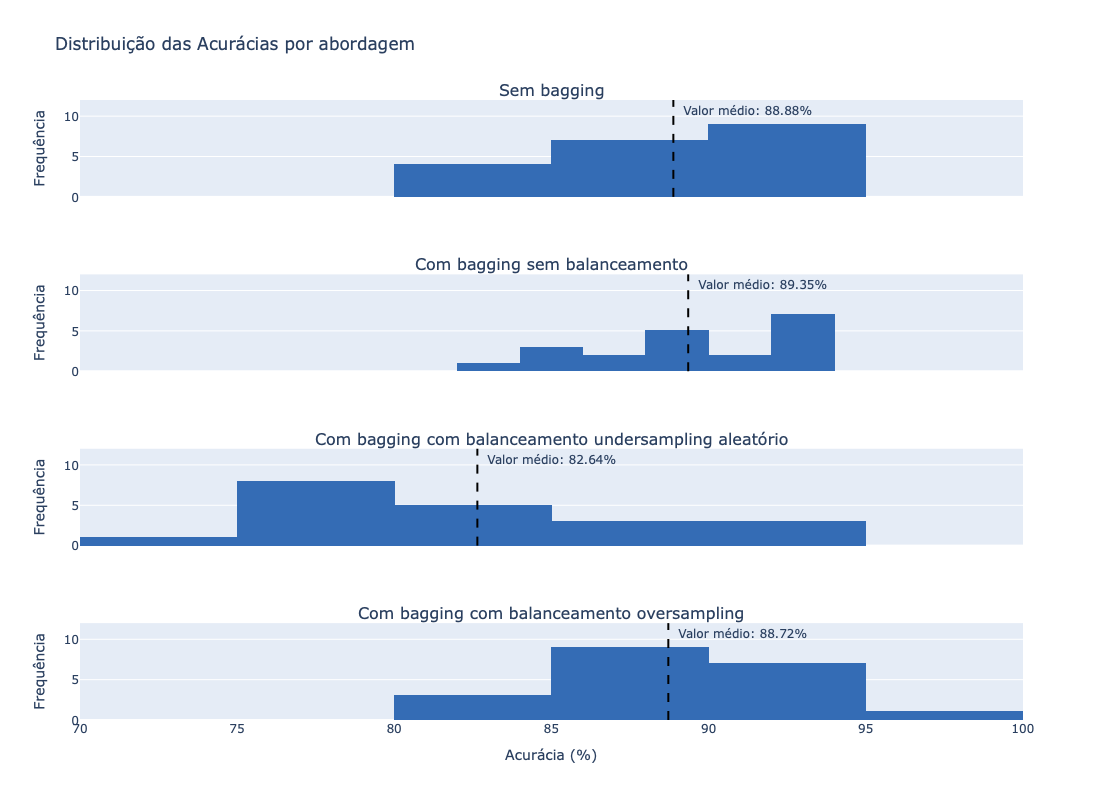

In [80]:
with open('../data/processed/knn_res.pkl', 'rb') as file: 
    knn_res = pickle.load(file)

with open('../data/processed/knn_imb_bag_res.pkl', 'rb') as file: 
    knn_imb_bag_res = pickle.load(file)

with open('../data/processed/knn_bal_und_bag_res.pkl', 'rb') as file: 
    knn_bal_und_bag_res = pickle.load(file)

with open('../data/processed/knn_bal_ovr_bag_res.pkl', 'rb') as file: 
    knn_bal_ovr_bag_res = pickle.load(file)

knn_accs = {
    'Sem bagging': [v * 100 for v in knn_res['accuracies']],
    'Com bagging sem balanceamento': [v * 100 for v in knn_imb_bag_res['accuracies']],
    'Com bagging com balanceamento undersampling aleatório': [v * 100 for v in knn_bal_und_bag_res['accuracies']],
    'Com bagging com balanceamento oversampling': [v * 100 for v in knn_bal_ovr_bag_res['accuracies']],
}

plot_accuracies(knn_accs)

### Testes das premissas para escolha adequada do teste

#### Teste de normalidade

Para a escolha do teste que será aplicado, faz-se necessário primeiramente a verificação da normalidade das amostras. Dito isto, vamos realizar o teste de normalidade nos nossos dados. Adotaremos $\alpha = 5\%$ para o nosso teste, cujas hipóteses são:
* $H_0$: as amostras vêm de uma população com distribuição normal
* $H_1$: as amostras não vêm de uma população com distribuição normal

In [55]:
for strategy, strategy_accs in knn_accs.items():
     norm_test = ss.normaltest(strategy_accs)
     p_values = norm_test.pvalue 

     print(f'{strategy}: {p_values}')

Sem bagging: 0.38764332083486175
Com bagging sem balanceamento: 0.5135784022733998
Com bagging com balanceamento undersampling aleatório: 0.5247257141058129
Com bagging com balanceamento oversampling: 0.8835950124342377


A 5% de significância não há evidências estatísticas suficientes para rejeitar a hipótese nula de que elas seguem uma distribuição normal.

#### Teste de variância

Não descartada a hipótese que os dados seguem uma distribuição normal, verifiquemos agora a hipótese de que as amostras advém de populações com variâncias iguais. Dito isto, vamos realizar testes para esta verificação. Adotaremos $\alpha = 5\%$ para o nosso teste, cujas hipóteses são:
* $H_0$: as amostras vêm de uma população com variância igual.
* $H_1$: as amostras vêm de uma população com variância diferente.

In [56]:
# O teste de Levene é robusto contra desvios da normalidade.
ss.levene(*[knn_accs[k] for k in knn_accs.keys()])

LeveneResult(statistic=np.float64(2.250625108494606), pvalue=np.float64(0.08924396317788118))

A 5% de significância não há evidências estatísticas suficientes para rejeitar a hipótese nula de que as variâncias (e, portanto, os desvios-padrão) são consideradas iguais.

In [57]:
# O teste de Bartlett é mais sensível a desvios da normalidade.
ss.bartlett(*[knn_accs[k] for k in knn_accs.keys()])

BartlettResult(statistic=np.float64(4.40294689193644), pvalue=np.float64(0.22111229736157664))

A 5% de significância não há evidências estatísticas suficientes para rejeitar a hipótese nula de que as variâncias (e, portanto, os desvios-padrão) são consideradas iguais.

### Testes de Hipótese sobre a Média

#### Teste T para 2 Amostras

In [61]:
knn_mean_accs = {k: np.mean(v) for k, v in knn_accs.items() if k != 'Sem bagging'}
knn_best_bag_key = max(knn_mean_accs, key=knn_mean_accs.get)

print(f'Comparando a melhor estratégia de Bagging ({knn_best_bag_key} - {knn_mean_accs[knn_best_bag_key]:.2f})%', end='\n\n')

ss.ttest_ind(knn_accs['Sem bagging'], knn_accs[knn_best_bag_key], alternative="less", equal_var=True)
# ss.mannwhitneyu(knn_accs['Sem bagging'], knn_accs[knn_best_bag_key], alternative="less")

Comparando a melhor estratégia de Bagging (Com bagging sem balanceamento - 89.35)%



TtestResult(statistic=np.float64(-0.4109263799634242), pvalue=np.float64(0.3417173503054145), df=np.float64(38.0))

#### ANOVA

Hipóteses
* $H_0$: os grupos possuem a mesma média populacional
* $H_1$: os grupos possuem média populacional diferente

In [10]:
ss.f_oneway(*[knn_accs[k] for k in knn_accs.keys()])

F_onewayResult(statistic=np.float64(12.325897536043337), pvalue=np.float64(1.1811119156611214e-06))

A 5% de significância há evidências estatísticas suficientes para rejeitar a hipótese nula de que os grupos possuam média populacional igual.

#### Kruskal-Wallis

Hipóteses
* $H_0$: os grupos possuem a mesma média populacional
* $H_1$: os grupos possuem média populacional diferente

In [11]:
ss.kruskal(*[knn_accs[k] for k in knn_accs.keys()])

KruskalResult(statistic=np.float64(19.872435218527183), pvalue=np.float64(0.00018039449626330119))

A 5% de significância há evidências estatísticas suficientes para rejeitar a hipótese nula de que os grupos possuam média populacional igual.

## DT

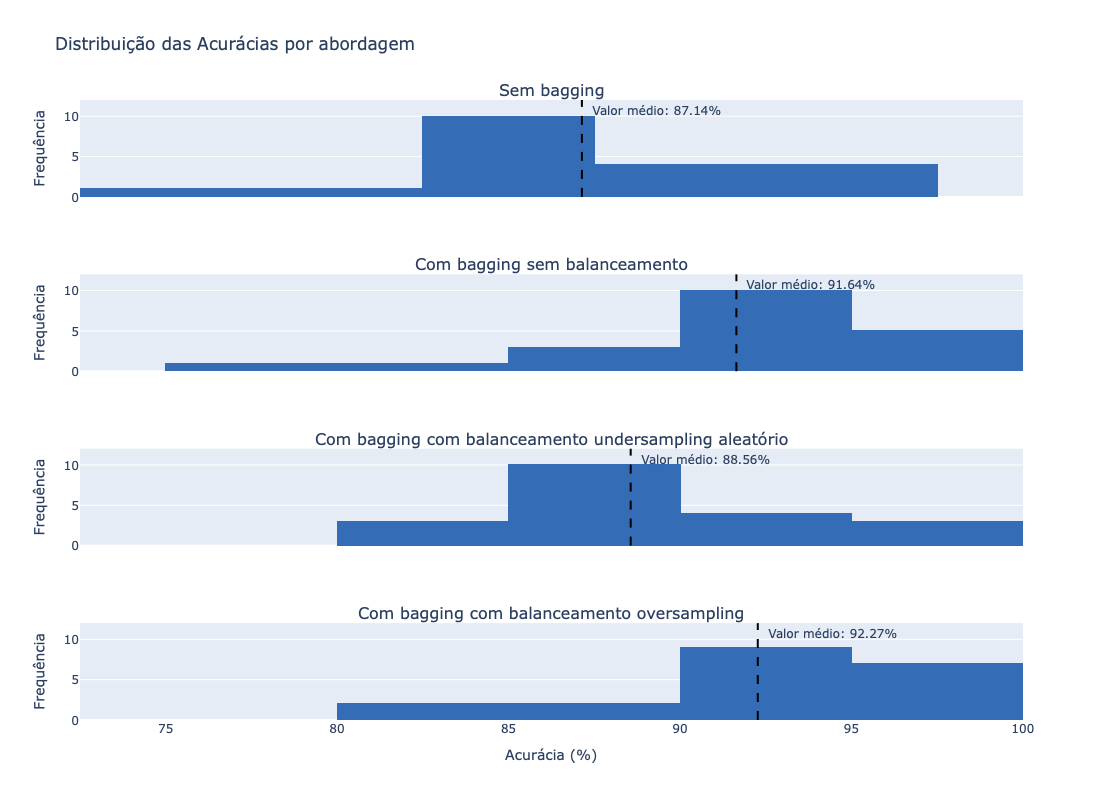

In [81]:
with open('../data/processed/dt_res.pkl', 'rb') as file: 
    dt_res = pickle.load(file)

with open('../data/processed/dt_imb_bag_res.pkl', 'rb') as file: 
    dt_imb_bag_res = pickle.load(file)

with open('../data/processed/dt_bal_und_bag_res.pkl', 'rb') as file: 
    dt_bal_und_bag_res = pickle.load(file)

with open('../data/processed/dt_bal_ovr_bag_res.pkl', 'rb') as file: 
    dt_bal_ovr_bag_res = pickle.load(file)

dt_accs = {
    'Sem bagging': [v * 100 for v in dt_res['accuracies']],
    'Com bagging sem balanceamento': [v * 100 for v in dt_imb_bag_res['accuracies']],
    'Com bagging com balanceamento undersampling aleatório': [v * 100 for v in dt_bal_und_bag_res['accuracies']],
    'Com bagging com balanceamento oversampling': [v * 100 for v in dt_bal_ovr_bag_res['accuracies']],
}

plot_accuracies(dt_accs)

### Testes das premissas para escolha adequada do teste

#### Teste de normalidade

Para a escolha do teste que será aplicado, faz-se necessário primeiramente a verificação da normalidade das amostras. Dito isto, vamos realizar o teste de normalidade nos nossos dados. Adotaremos $\alpha = 5\%$ para o nosso teste, cujas hipóteses são:
* $H_0$: as amostras vêm de uma população com distribuição normal
* $H_1$: as amostras não vêm de uma população com distribuição normal

In [13]:
for strategy, strategy_accs in dt_accs.items():
     norm_test = ss.normaltest(strategy_accs)
     p_values = norm_test.pvalue

     print(f'{strategy}: {p_values}')

Sem bagging: 0.6823828866431272
Com bagging sem balanceamento: 0.015303776638033954
Com bagging com balanceamento undersampling aleatório: 0.8299307344477307
Com bagging com balanceamento oversampling: 0.14002951168003935


A 5% de significância não há evidências estatísticas suficientes para rejeitar a hipótese nula de que elas seguem uma distribuição normal.

#### Teste de variância

Não descartada a hipótese que os dados seguem uma distribuição normal, verifiquemos agora a hipótese de que as amostras advém de populações com variâncias iguais. Dito isto, vamos realizar testes para esta verificação. Adotaremos $\alpha = 5\%$ para o nosso teste, cujas hipóteses são:
* $H_0$: as amostras vêm de uma população com variância igual.
* $H_1$: as amostras vêm de uma população com variância diferente.

In [14]:
# O teste de Levene é robusto contra desvios da normalidade.
ss.levene(*[dt_accs[k] for k in dt_accs.keys()])

LeveneResult(statistic=np.float64(0.3118231679678896), pvalue=np.float64(0.8167721810082167))

A 5% de significância não há evidências estatísticas suficientes para rejeitar a hipótese nula de que as variâncias (e, portanto, os desvios-padrão) são consideradas iguais.

In [15]:
# O teste de Bartlett é mais sensível a desvios da normalidade.
ss.bartlett(*[dt_accs[k] for k in dt_accs.keys()])

BartlettResult(statistic=np.float64(0.7483723664315745), pvalue=np.float64(0.8617715166284198))

A 5% de significância não há evidências estatísticas suficientes para rejeitar a hipótese nula de que as variâncias (e, portanto, os desvios-padrão) são consideradas iguais.

### Testes de Hipótese sobre a Média

#### Teste T para 2 Amostras

In [82]:
dt_mean_accs = {k: np.mean(v) for k, v in dt_accs.items() if k != 'Sem bagging'}
dt_best_bag_key = max(dt_mean_accs, key=dt_mean_accs.get)

print(f'Comparando a melhor estratégia de Bagging ({dt_best_bag_key} - {dt_mean_accs[dt_best_bag_key]:.2f})%', end='\n\n')

ss.ttest_ind(dt_accs['Sem bagging'], dt_accs[dt_best_bag_key], alternative="less", equal_var=True)
# ss.mannwhitneyu(dt_accs['Sem bagging'], dt_accs[dt_best_bag_key], alternative="less")

Comparando a melhor estratégia de Bagging (Com bagging com balanceamento oversampling - 92.27)%



TtestResult(statistic=np.float64(-3.4973740795518373), pvalue=np.float64(0.0006070148687871802), df=np.float64(38.0))

#### ANOVA

Hipóteses
* $H_0$: os grupos possuem a mesma média populacional
* $H_1$: os grupos possuem média populacional diferente

In [ ]:
ss.f_oneway(*[dt_accs[k] for k in dt_accs.keys()])

A 5% de significância há evidências estatísticas suficientes para rejeitar a hipótese nula de que os grupos possuam média populacional igual.

#### Kruskal-Wallis

Hipóteses
* $H_0$: os grupos possuem a mesma média populacional
* $H_1$: os grupos possuem média populacional diferente

In [ ]:
ss.kruskal(*[dt_accs[k] for k in dt_accs.keys()])

A 5% de significância há evidências estatísticas suficientes para rejeitar a hipótese nula de que os grupos possuam média populacional igual.

## SVM

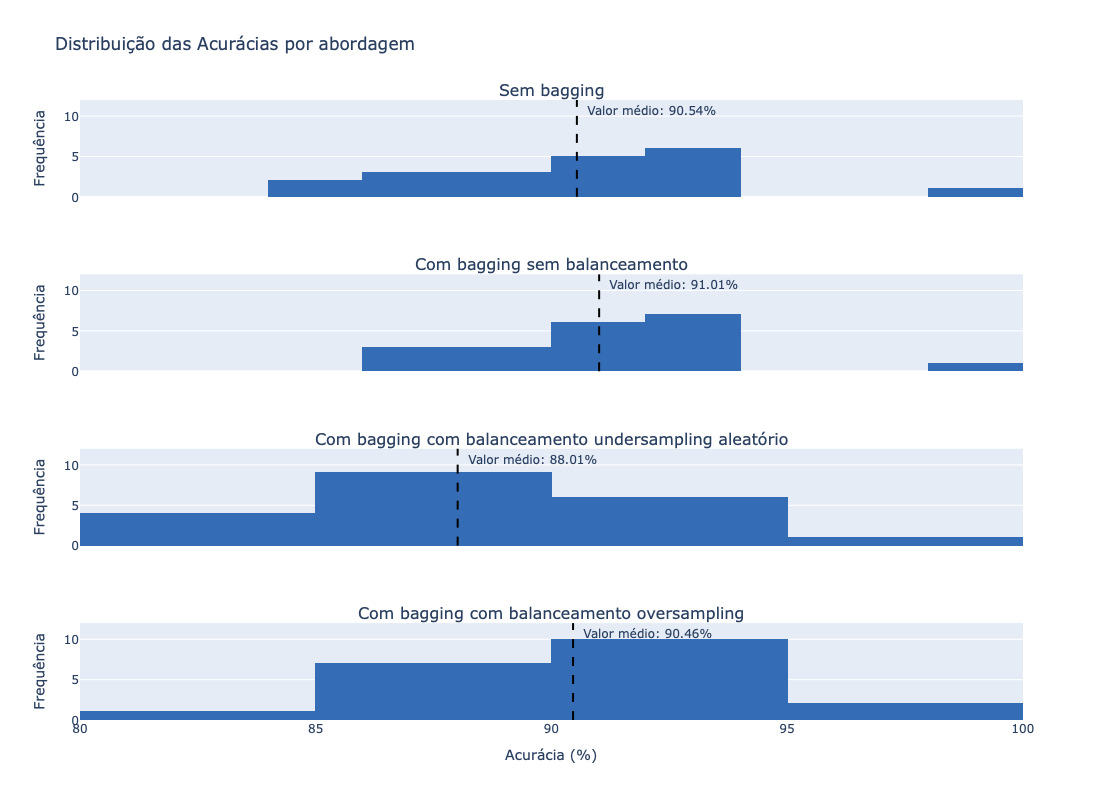

In [83]:
with open('../data/processed/svm_res.pkl', 'rb') as file: 
    svm_res = pickle.load(file)

with open('../data/processed/svm_imb_bag_res.pkl', 'rb') as file: 
    svm_imb_bag_res = pickle.load(file)

with open('../data/processed/svm_bal_und_bag_res.pkl', 'rb') as file: 
    svm_bal_und_bag_res = pickle.load(file)

with open('../data/processed/svm_bal_ovr_bag_res.pkl', 'rb') as file: 
    svm_bal_ovr_bag_res = pickle.load(file)

svm_accs = {
    'Sem bagging': [v * 100 for v in svm_res['accuracies']],
    'Com bagging sem balanceamento': [v * 100 for v in svm_imb_bag_res['accuracies']],
    'Com bagging com balanceamento undersampling aleatório': [v * 100 for v in svm_bal_und_bag_res['accuracies']],
    'Com bagging com balanceamento oversampling': [v * 100 for v in svm_bal_ovr_bag_res['accuracies']],
}

plot_accuracies(svm_accs)

### Testes das premissas para escolha adequada do teste

#### Teste de normalidade

Para a escolha do teste que será aplicado, faz-se necessário primeiramente a verificação da normalidade das amostras. Dito isto, vamos realizar o teste de normalidade nos nossos dados. Adotaremos $\alpha = 5\%$ para o nosso teste, cujas hipóteses são:
* $H_0$: as amostras vêm de uma população com distribuição normal
* $H_1$: as amostras não vêm de uma população com distribuição normal

In [ ]:
for strategy, strategy_accs in svm_accs.items():
     norm_test = ss.normaltest(strategy_accs)
     p_values = norm_test.pvalue

     print(f'{strategy}: {p_values}')

A 5% de significância não há evidências estatísticas suficientes para rejeitar a hipótese nula de que elas seguem uma distribuição normal.

#### Teste de variância

Não descartada a hipótese que os dados seguem uma distribuição normal, verifiquemos agora a hipótese de que as amostras advém de populações com variâncias iguais. Dito isto, vamos realizar testes para esta verificação. Adotaremos $\alpha = 5\%$ para o nosso teste, cujas hipóteses são:
* $H_0$: as amostras vêm de uma população com variância igual.
* $H_1$: as amostras vêm de uma população com variância diferente.

In [ ]:
# O teste de Levene é robusto contra desvios da normalidade.
ss.levene(*[svm_accs[k] for k in svm_accs.keys()])

A 5% de significância não há evidências estatísticas suficientes para rejeitar a hipótese nula de que as variâncias (e, portanto, os desvios-padrão) são consideradas iguais.

In [ ]:
# O teste de Bartlett é mais sensível a desvios da normalidade.
ss.bartlett(*[svm_accs[k] for k in svm_accs.keys()])

A 5% de significância não há evidências estatísticas suficientes para rejeitar a hipótese nula de que as variâncias (e, portanto, os desvios-padrão) são consideradas iguais.

### Testes de Hipótese sobre a Média

#### Teste T para 2 Amostras

In [84]:
svm_mean_accs = {k: np.mean(v) for k, v in svm_accs.items() if k != 'Sem bagging'}
svm_best_bag_key = max(svm_mean_accs, key=svm_mean_accs.get)

print(f'Comparando a melhor estratégia de Bagging ({svm_best_bag_key} - {svm_mean_accs[svm_best_bag_key]:.2f})%', end='\n\n')

ss.ttest_ind(svm_accs['Sem bagging'], svm_accs[svm_best_bag_key], alternative="less", equal_var=True)
# ss.mannwhitneyu(svm_accs['Sem bagging'], svm_accs[svm_best_bag_key], alternative="less")

Comparando a melhor estratégia de Bagging (Com bagging sem balanceamento - 91.01)%



TtestResult(statistic=np.float64(-0.5149589374554333), pvalue=np.float64(0.3047821918870215), df=np.float64(38.0))

#### ANOVA

Hipóteses
* $H_0$: os grupos possuem a mesma média populacional
* $H_1$: os grupos possuem média populacional diferente

In [ ]:
ss.f_oneway(*[svm_accs[k] for k in svm_accs.keys()])

A 5% de significância há evidências estatísticas suficientes para rejeitar a hipótese nula de que os grupos possuam média populacional igual.

#### Kruskal-Wallis

Hipóteses
* $H_0$: os grupos possuem a mesma média populacional
* $H_1$: os grupos possuem média populacional diferente

In [ ]:
ss.kruskal(*[svm_accs[k] for k in svm_accs.keys()])

A 5% de significância há evidências estatísticas suficientes para rejeitar a hipótese nula de que os grupos possuam média populacional igual.

---
## Playground

In [97]:
def get_mean_f1s(res):
    f1s = []
    
    for n in range(len(res['f1-scores']['Pastry'])):  # Tamanho das listas é o mesmo para cada classe
        f1s.append(np.mean([res['f1-scores'][k][n] for k in res['f1-scores'].keys()]))

    return f1s

In [100]:
svm_f1s = {
    'Sem bagging': [v * 100 for v in get_mean_f1s(svm_res)],
    'Com bagging sem balanceamento': [v * 100 for v in get_mean_f1s(svm_imb_bag_res)],
    'Com bagging com balanceamento undersampling aleatório': [v * 100 for v in get_mean_f1s(svm_bal_und_bag_res)],
    'Com bagging com balanceamento oversampling': [v * 100 for v in get_mean_f1s(svm_bal_ovr_bag_res)],
}

svm_f1s

{'Sem bagging': [np.float64(87.18281210272058),
  np.float64(94.20217209690894),
  np.float64(82.18843843843842),
  np.float64(88.80622783061808),
  np.float64(87.3872509079296),
  np.float64(78.29598506069094),
  np.float64(90.94796735059515),
  np.float64(98.61310377809662),
  np.float64(88.71794871794872),
  np.float64(80.95314505776638),
  np.float64(85.55555555555556),
  np.float64(89.71662596662598),
  np.float64(94.40758759644208),
  np.float64(91.79401180175174),
  np.float64(87.59103641456582),
  np.float64(94.65201465201466),
  np.float64(89.04245709123758),
  np.float64(88.75179340028694),
  np.float64(89.75014145745853),
  np.float64(89.63869463869464)],
 'Com bagging sem balanceamento': [np.float64(88.66223399883131),
  np.float64(94.20217209690894),
  np.float64(83.34430776291241),
  np.float64(91.80274351006058),
  np.float64(87.3872509079296),
  np.float64(81.47058823529413),
  np.float64(90.63990103463787),
  np.float64(98.61310377809662),
  np.float64(89.0493327335432

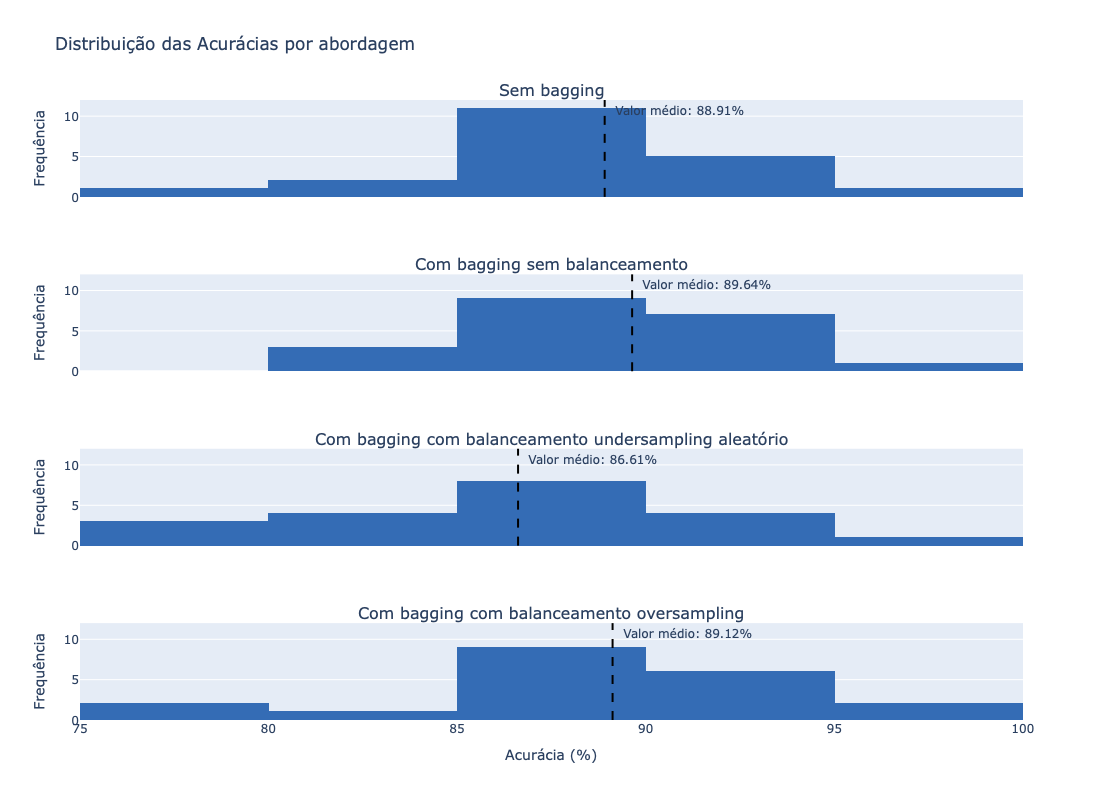

In [102]:
plot_accuracies(svm_f1s)

In [101]:
svm_mean_f1s = {k: np.mean(v) for k, v in svm_f1s.items() if k != 'Sem bagging'}
svm_best_bag_key = max(svm_mean_f1s, key=svm_mean_f1s.get)

print(f'Comparando a melhor estratégia de Bagging ({svm_best_bag_key} - {svm_mean_f1s[svm_best_bag_key]:.2f})%', end='\n\n')

ss.ttest_ind(svm_f1s['Sem bagging'], svm_f1s[svm_best_bag_key], alternative="less", equal_var=True)
# ss.mannwhitneyu(svm_f1s['Sem bagging'], svm_f1s[svm_best_bag_key], alternative="less")

Comparando a melhor estratégia de Bagging (Com bagging sem balanceamento - 89.64)%



TtestResult(statistic=np.float64(-0.515170968665329), pvalue=np.float64(0.3047088190990496), df=np.float64(38.0))